# Train floor number data with CNN

## Do setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

## load and display some data image

In [2]:
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 26
def extract_data(filename, num_images):
  """Extract the images into a 4D tensor [image index, y, x, channels].

  Values are rescaled from [0, 255] down to [-0.5, 0.5].
  """
  filepath = os.path.join(WORK_DIRECTORY, filename)
  print('Extracting', filepath)
  with open(filepath, mode='rb') as bytestream:
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data


def extract_labels(filename, num_images):
  """Extract the labels into a vector of int64 label IDs."""
  filepath = os.path.join(WORK_DIRECTORY, filename)
  print('Extracting', filepath)
  with open(filepath, mode='rb') as bytestream:
    buf = bytestream.read(1 * num_images)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
  return labels

# Get the data.
train_data_filename = 'floor_train_data.bin'
train_labels_filename = 'floor_train_label.bin'
test_data_filename = 'floor_test_data.bin'
test_labels_filename = 'floor_test_label.bin'

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, 27863)
train_labels = extract_labels(train_labels_filename, 27863)
test_data = extract_data(test_data_filename, 7800)
test_labels = extract_labels(test_labels_filename, 7800)

Extracting data/floor_train_data.bin
Extracting data/floor_train_label.bin
Extracting data/floor_test_data.bin
Extracting data/floor_test_label.bin


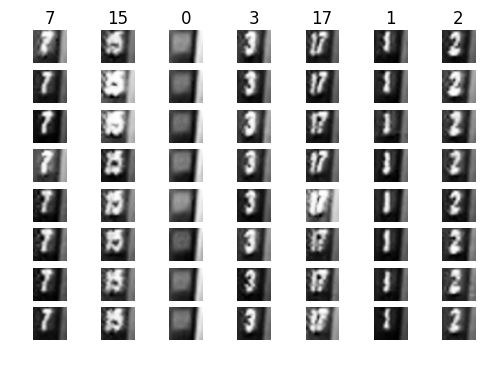

In [3]:
class_7 = np.random.choice([x for x in range(NUM_LABELS)], 7, replace=False)
for y, cls in enumerate(class_7):
    idxs = np.flatnonzero(train_labels == cls)
    idxs = np.random.choice(idxs, 8, replace=False) # chose 8 for each label
    #print(cls, idxs)
    for i, idx in enumerate(idxs):
        plt_idx = i * 7 + y + 1
        plt.subplot(8, 7, plt_idx)
        plt.imshow((train_data[idx,:,:,:] * PIXEL_DEPTH + PIXEL_DEPTH / 2.0).reshape((IMAGE_SIZE, IMAGE_SIZE)).astype('uint8'), \
                  cmap='gray')
        plt.axis('off')
        if i==0:
            plt.title(cls)

In [15]:
# define tensorflow CNN network
tf.reset_default_graph()
tf_X = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS], name='data_node')
tf_y = tf.placeholder(tf.int64, [None], name='labels_node')

def simple_model(tf_X, tf_y):
    conv1 = tf.layers.conv2d(inputs=tf_X, \
                            filters=32, kernel_size=5, \
                            activation=tf.nn.relu) #-->24x24x32
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2) #12x12x32
    conv2 = tf.layers.conv2d(inputs=pool1, \
                            filters=64, kernel_size=5, \
                            activation=tf.nn.relu) #out:8x8x64
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2) #out:4x4x64
    flat = tf.reshape(pool2, shape=[-1, 4*4*64])
    y_out = tf.layers.dense(inputs=flat, units=NUM_LABELS)
    
    return y_out #[batch_size, NUM_LABELS]
    
y_out = simple_model(tf_X, tf_y)
total_loss = tf.losses.hinge_loss(tf.one_hot(tf_y, NUM_LABELS), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# optimizer
optimizer = tf.train.AdamOptimizer(5e-4)
train_step = optimizer.minimize(mean_loss)

## A trial of training
Feed all data in and do training just one time to see how the loss will going to be.  And set a high learning rate , put train_step in the map to overfit the data. Note that in below code, there is no training and validation dataset, which is un-common in an state-of-art machine learning. 

(64, 28, 28, 1)
Training...


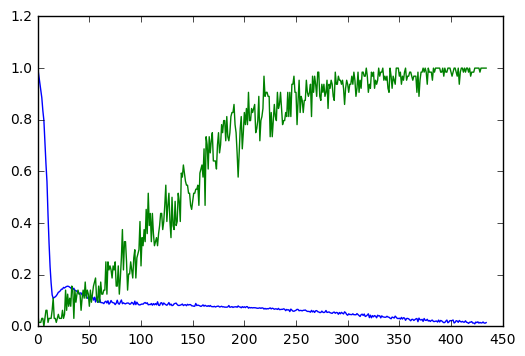

In [16]:
BATCH_SIZE = 64
data_cnt = train_data.shape[0]
batch_cnt = train_data.shape[0] // BATCH_SIZE
print(train_data[0:64,:].shape)
correct_prediction = tf.equal(tf.argmax(y_out,1), tf_y)
lost, accs = [], []
with tf.Session() as sess:
    with tf.device("/gpu:0"):
        sess.run(tf.global_variables_initializer())
        print('Training...')
        # shuffle indicies
        train_indicies = np.arange(data_cnt)
        np.random.shuffle(train_indicies)
        
        for i in range(batch_cnt):
            idx = train_indicies[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            feed_dict = {tf_X: train_data[idx,:], \
                         tf_y: train_labels[idx]}
            fetches = [mean_loss, correct_prediction, train_step]
            l,c, _ = sess.run(fetches=fetches, feed_dict=feed_dict)
            #print(l, np.sum(c))
            accs.append(np.sum(c)/BATCH_SIZE)
            lost.append(l)

# plot accuracy 
plt.plot(lost)
plt.plot(accs)

## The real training
Split the dataset to train, validation and test sets. As of now we already have 27863 train data. Will use 340*64=21760 data as training data (try to split (train_count, validation_count)=(0.78, 0.22))

In [17]:
total_cnt, train_cnt = 27863, 21760
train_indices = np.arange(total_cnt)
np.random.shuffle(train_indices)
X_train = train_data[train_indices[:train_cnt], :]
y_train = train_labels[train_indices[:train_cnt]]
X_val   = train_data[train_indices[train_cnt:], :]
y_val   = train_labels[train_indices[train_cnt:]]
print('--Train data shape----       --Validation data shape----')
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

--Train data shape----       --Validation data shape----
(21760, 28, 28, 1) (21760,) (6103, 28, 28, 1) (6103,)


In [18]:
# run model function
is_training = tf.placeholder(tf.bool)
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), tf_y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training # for training replace accuracy with minimize lost
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(Xd.shape[0]//batch_size):
            # generate indicies for the batch
            idx = train_indicies[i*batch_size:(i+1)*batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {tf_X: Xd[idx,:],
                         tf_y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

Training
Iteration 0: with minibatch training loss = 0.993 and accuracy of 0.031
Iteration 100: with minibatch training loss = 0.0934 and accuracy of 0.27
Iteration 200: with minibatch training loss = 0.0769 and accuracy of 0.73
Iteration 300: with minibatch training loss = 0.0519 and accuracy of 0.91
Epoch 1, Overall loss = 0.102 and accuracy of 0.549


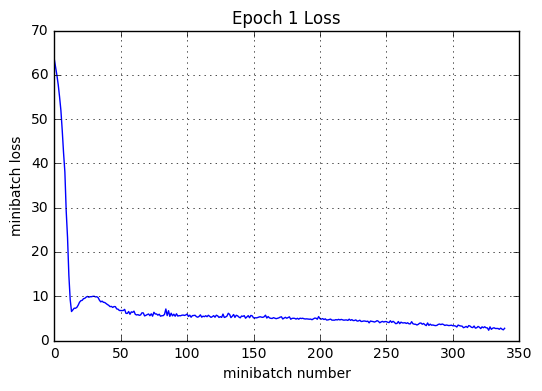

Iteration 400: with minibatch training loss = 0.0225 and accuracy of 0.98
Iteration 500: with minibatch training loss = 0.0103 and accuracy of 1
Iteration 600: with minibatch training loss = 0.0046 and accuracy of 0.98
Epoch 2, Overall loss = 0.0127 and accuracy of 0.989


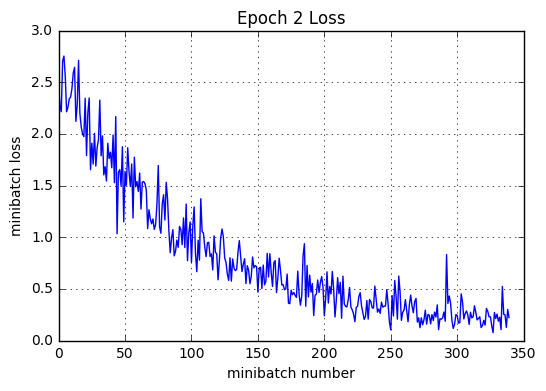

Iteration 700: with minibatch training loss = 0.0035 and accuracy of 1
Iteration 800: with minibatch training loss = 0.00148 and accuracy of 1
Iteration 900: with minibatch training loss = 0.000447 and accuracy of 1
Iteration 1000: with minibatch training loss = 0.000443 and accuracy of 1
Epoch 3, Overall loss = 0.00175 and accuracy of 0.998


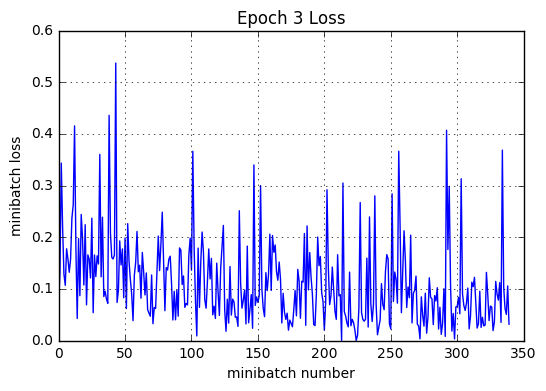

Iteration 1100: with minibatch training loss = 6.97e-05 and accuracy of 1
Iteration 1200: with minibatch training loss = 0.000992 and accuracy of 1
Iteration 1300: with minibatch training loss = 0.000922 and accuracy of 1
Epoch 4, Overall loss = 0.000982 and accuracy of 0.998


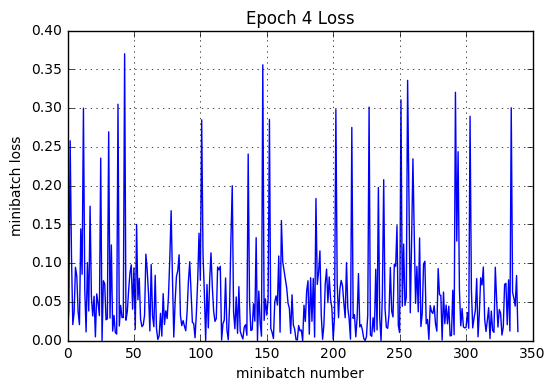

Iteration 1400: with minibatch training loss = 0.000103 and accuracy of 1
Iteration 1500: with minibatch training loss = 0.000483 and accuracy of 1
Iteration 1600: with minibatch training loss = 0.000291 and accuracy of 1
Epoch 5, Overall loss = 0.000772 and accuracy of 0.998


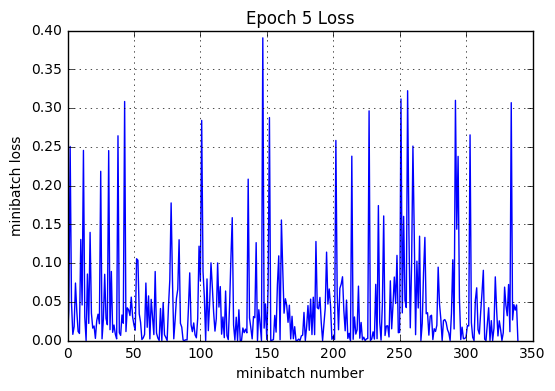

Iteration 1700: with minibatch training loss = 0 and accuracy of 1
Iteration 1800: with minibatch training loss = 0.000778 and accuracy of 1
Iteration 1900: with minibatch training loss = 3.19e-05 and accuracy of 1
Iteration 2000: with minibatch training loss = 2.7e-05 and accuracy of 1
Epoch 6, Overall loss = 0.000673 and accuracy of 0.998


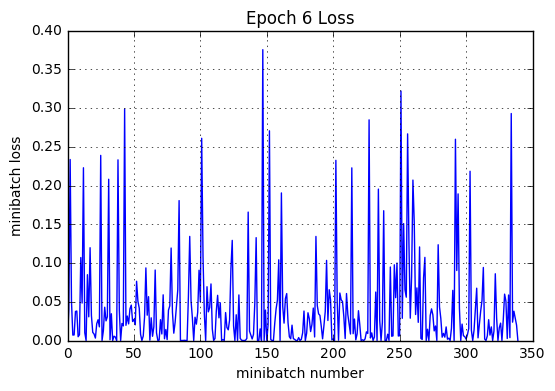

Iteration 2100: with minibatch training loss = 3.1e-05 and accuracy of 1
Iteration 2200: with minibatch training loss = 0 and accuracy of 1
Iteration 2300: with minibatch training loss = 0.00352 and accuracy of 0.98
Epoch 7, Overall loss = 0.000554 and accuracy of 0.999


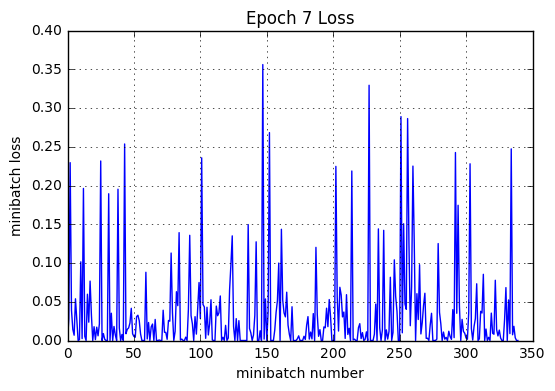

Iteration 2400: with minibatch training loss = 0.00102 and accuracy of 1
Iteration 2500: with minibatch training loss = 0.000338 and accuracy of 1
Iteration 2600: with minibatch training loss = 0.000449 and accuracy of 1
Iteration 2700: with minibatch training loss = 0 and accuracy of 1
Epoch 8, Overall loss = 0.000517 and accuracy of 0.999


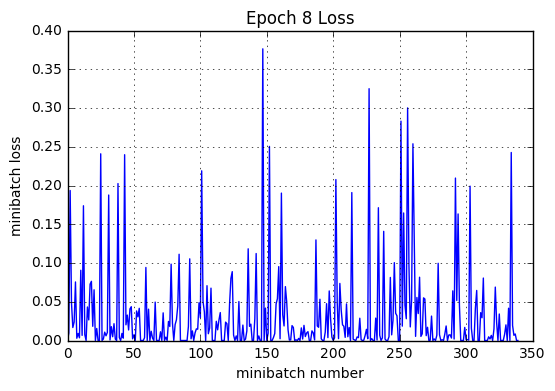

Iteration 2800: with minibatch training loss = 0 and accuracy of 1
Iteration 2900: with minibatch training loss = 0.000124 and accuracy of 1
Iteration 3000: with minibatch training loss = 0.000488 and accuracy of 1
Epoch 9, Overall loss = 0.000457 and accuracy of 0.998


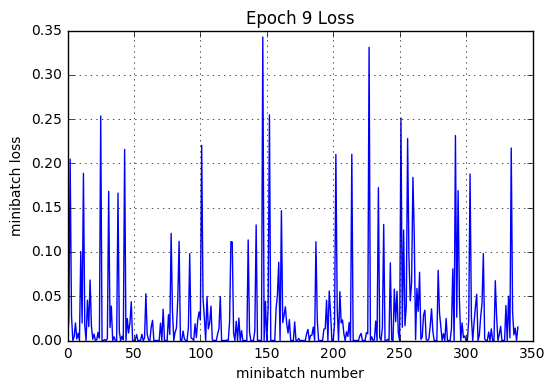

Iteration 3100: with minibatch training loss = 1.66e-05 and accuracy of 1
Iteration 3200: with minibatch training loss = 0 and accuracy of 1
Iteration 3300: with minibatch training loss = 0.000193 and accuracy of 1
Epoch 10, Overall loss = 0.000442 and accuracy of 0.999


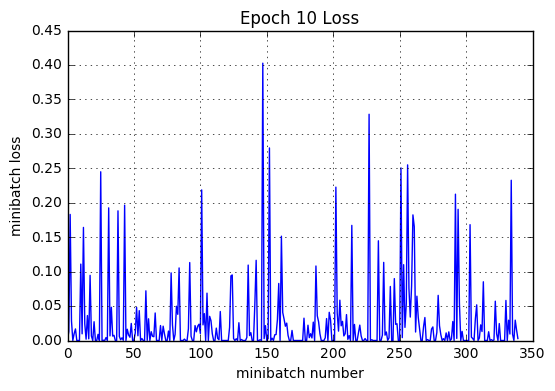

Validation
Epoch 1, Overall loss = 0.000718 and accuracy of 0.994


(0.00071842148860355845, 0.99393740783221363)

In [19]:
# training
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('Training')
run_model(session=sess, predict=y_out, loss_val=mean_loss, Xd=X_train, yd=y_train, \
         epochs=10, batch_size=64, print_every=100, \
         training=train_step, plot_losses=True)
print('Validation')
run_model(session=sess, predict=y_out, loss_val=mean_loss, Xd=X_val, yd=y_val, \
         epochs=1, batch_size=64)

## Test result

Test
Epoch 1, Overall loss = 1.5e-05 and accuracy of 0.993


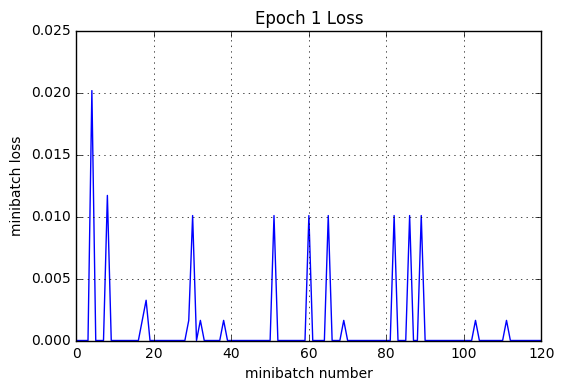

(1.4999076762857536e-05, 0.99282051282051287)

In [20]:
print('Test')
run_model(session=sess, predict=y_out, loss_val=mean_loss, Xd=test_data, yd=test_labels, \
         epochs=1, batch_size=64, plot_losses=True)

In [21]:
saver = tf.train.Saver()
saver.save(sess, './mnist_model')

'./mnist_model'

In [22]:
node_names = [node.name for node in tf.get_default_graph().as_graph_def().node]
print(node_names)

['data_node', 'labels_node', 'conv2d/kernel/Initializer/random_uniform/shape', 'conv2d/kernel/Initializer/random_uniform/min', 'conv2d/kernel/Initializer/random_uniform/max', 'conv2d/kernel/Initializer/random_uniform/RandomUniform', 'conv2d/kernel/Initializer/random_uniform/sub', 'conv2d/kernel/Initializer/random_uniform/mul', 'conv2d/kernel/Initializer/random_uniform', 'conv2d/kernel', 'conv2d/kernel/Assign', 'conv2d/kernel/read', 'conv2d/bias/Initializer/Const', 'conv2d/bias', 'conv2d/bias/Assign', 'conv2d/bias/read', 'conv2d/convolution/Shape', 'conv2d/convolution/dilation_rate', 'conv2d/convolution', 'conv2d/BiasAdd', 'conv2d/Relu', 'max_pooling2d/MaxPool', 'conv2d_1/kernel/Initializer/random_uniform/shape', 'conv2d_1/kernel/Initializer/random_uniform/min', 'conv2d_1/kernel/Initializer/random_uniform/max', 'conv2d_1/kernel/Initializer/random_uniform/RandomUniform', 'conv2d_1/kernel/Initializer/random_uniform/sub', 'conv2d_1/kernel/Initializer/random_uniform/mul', 'conv2d_1/kernel/I

In [23]:
for op in tf.get_default_graph().get_operations():  
    print(op.name)  

data_node
labels_node
conv2d/kernel/Initializer/random_uniform/shape
conv2d/kernel/Initializer/random_uniform/min
conv2d/kernel/Initializer/random_uniform/max
conv2d/kernel/Initializer/random_uniform/RandomUniform
conv2d/kernel/Initializer/random_uniform/sub
conv2d/kernel/Initializer/random_uniform/mul
conv2d/kernel/Initializer/random_uniform
conv2d/kernel
conv2d/kernel/Assign
conv2d/kernel/read
conv2d/bias/Initializer/Const
conv2d/bias
conv2d/bias/Assign
conv2d/bias/read
conv2d/convolution/Shape
conv2d/convolution/dilation_rate
conv2d/convolution
conv2d/BiasAdd
conv2d/Relu
max_pooling2d/MaxPool
conv2d_1/kernel/Initializer/random_uniform/shape
conv2d_1/kernel/Initializer/random_uniform/min
conv2d_1/kernel/Initializer/random_uniform/max
conv2d_1/kernel/Initializer/random_uniform/RandomUniform
conv2d_1/kernel/Initializer/random_uniform/sub
conv2d_1/kernel/Initializer/random_uniform/mul
conv2d_1/kernel/Initializer/random_uniform
conv2d_1/kernel
conv2d_1/kernel/Assign
conv2d_1/kernel/read
